In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## I Gaussian vector generator

In [27]:
def X_gauss(n:int=None,cov: np.array=np.identity(4),mean: np.array = np.zeros(4))->np.array:
    """
    Args:
        n,int: number of samples by default n=None ie a single sample
        cov,np.array: covariance matrix by default cov=np.identity(3)
        mean: mean value vector by default mean=np.zeros(3)

    Returns:
        n samples of the gaussian vector defined by the cov matrix and mean vector
    """
    
    return np.random.multivariate_normal(mean,cov,n)

## II COCO
$$COCO_{emp}(z,F,G)=\frac{1}{n}\sqrt{{\lVert \bar{K}^j\bar{K}^g \rVert}_2}$$
With $\bar{K}^f$ the matrix obtained via the projection $ \bar{K}^f  =  PK^fP$ with the projection operator $ P_{ij} = {\delta}_{ij}  - \frac{1}{n}$ and Gram matrix ${K^{f}}_{ij} =k_f(x_i,x_j)$. $\; \bar{K}^g$ is defined analogously.

In [28]:
def map_projection_op(i:int,j:int,n:int)-> float:
    """This function gives the value of Projector operator matrix coefficients
    Args:
        i : line number
        j : row number
        n : number of samples
    Returns:
        P_ij
    """
    if i==j:
        return 1-1/n
    else:
        return -1/n 
    
def map_kernel_gram(i:int,j:int,x:np.array,k:callable) -> float:
    """This function gives the value of the Gram matrix coefficients
    
    Args:
        i : line number
        j : row number
        x : samples vector
        k : kernel
    Returns:
        K_ij
    """
    return k(x[i],x[j])


def COCO(Kf:callable,Kg:callable,x:np.array,y:np.array)->float:
    """This function computes the constrained covariance for two kernels and some samples
    
    Args:
        Kf : first kernel
        Kg : second kernel
        x : samples from F
        y : samples from G
    Returns:
        COCO_emp
    """
    n= len(x)
    Kf_gram = np.array([list( map_kernel_gram(i,j,x,Kf) for i in range(n)) for j in range(n)])
    Kg_gram = np.array([list( map_kernel_gram(i,j,y,Kg) for i in range(n)) for j in range(n)])
    P = np.array([list( map_projection_op(i,j,n) for i in range(n)) for j in range(n)])
    Kf_bar = np.matmul(P,np.matmul(Kf_gram,P))
    Kg_bar = np.matmul(P,np.matmul(Kg_gram,P))

    return np.sqrt(np.linalg.norm(np.matmul(Kf_bar,Kg_bar),2))/n
    

In [29]:

def K_laplacian(x:np.ndarray,y:np.ndarray,factor:float)->float:
    """This function returns the evaluation of the laplacian kernel on x and y
    Args:
        x : random variable vector
        y : random variable vector
    Returns:
        k(x,y)
        
    """
    
    if type(x)==np.ndarray:
        return np.exp(-factor*np.linalg.norm(x-y,1))
    else:
        return np.exp(-factor*(abs(x-y)))

def K_gaussian(x:np.ndarray,y:np.ndarray,factor:float)->float:
    """This function returns the evaluation of the gaussian kernel on x and y
    
    Args:
        x : random variable vector
        y : random variable vector
    Returns:
        k(x,y)
    """
    
    if type(x)==np.ndarray:
        return np.exp(-factor*np.linalg.norm(x-y,2))
    else:
        return np.exp(-factor*((x-y)**2))


100%|██████████| 20/20 [01:55<00:00,  5.79s/it]


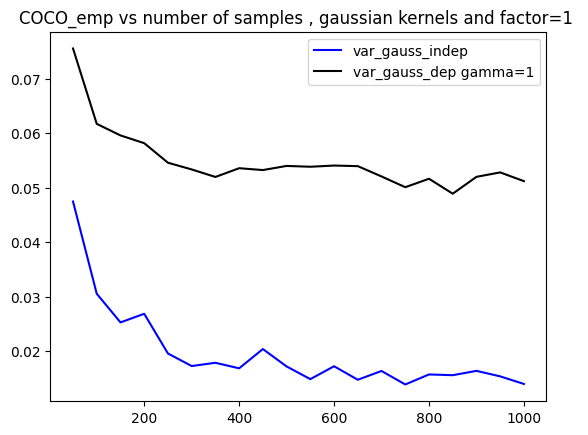

In [30]:
factor = 1
Kf = lambda x,y : K_gaussian(x,y,factor)
Kg = lambda x,y : K_gaussian(x,y,factor)
gamma = 1 # dependence factor
start_point = 50 # min number of samples
end_point = 1000 # max number of samples
step = 50 # gap between number of samples
x_axis = np.array(list(range(start_point,end_point+1,step)))
n_points = (end_point-start_point)//step +1
res_indep = np.empty(n_points) # results array for independent variables
res_dep = np.empty(n_points) # results array for dependent variables

cov = np.identity(4)
cov[1][0] =  0.5
cov[0][1] =  0.5
cov[1][2] =  0.25
cov[2][1] =  0.25
cov[2][3] =  0.75
cov[3][2] =  0.75
mean = np.array([0.5,1,0.6,0])

for i in tqdm(range(start_point,end_point+1,step)):
    k = (i-start_point)//step
    x = X_gauss(i,cov,mean)
    y = X_gauss(i,cov,mean)
    res_indep[k] = COCO(Kf,Kg,x,y)
    x2 = X_gauss(i,cov,mean)
    y2 = gamma*x2 +np.sqrt(1-gamma**2)*X_gauss(i,cov,mean)
    res_dep[k] = COCO(Kf,Kg,x2,y2)

plt.title("COCO_emp vs number of samples , gaussian kernels and factor={} ".format(factor))
plt.plot(x_axis,res_indep,color = "blue", label ="var_gauss_indep")
plt.plot(x_axis,res_dep,color = "black", label ="var_gauss_dep gamma={}".format(gamma))
plt.legend()
plt.show()


In [31]:
def K_polynomial(x,y,c:float,d:int):
    """
    Args:
        x : first vector of samples
        y : second vector of samples
        c : constant 
        d : degree of the polynomial
    """
    if type(x)==np.ndarray:
        return ((np.matmul(np.transpose(x),y) +c)**d)
    else:
        return np.exp(-factor*((x-y)**2))
    

100%|██████████| 20/20 [01:10<00:00,  3.54s/it]


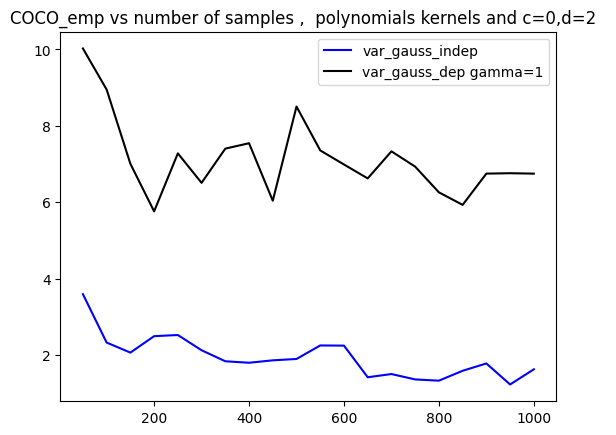

In [32]:
c = 0 # constant
d = 2 # degree of the polyomial

Kf = lambda x,y : K_polynomial(x,y,c,d)
Kg = lambda x,y : K_polynomial(x,y,c,d)

gamma = 1 # dependence factor
start_point = 50 # min number of samples
end_point = 1000 # max number of samples
step = 50 # gap between number of samples
x_axis = np.array(list(range(start_point,end_point+1,step)))

n_points = (end_point-start_point)//step +1
res_indep = np.empty(n_points) # results array for independent variables
res_dep = np.empty(n_points) # results array for dependent variables

cov = np.identity(4)
cov[1][0] =  0.5
cov[0][1] =  0.5
cov[1][2] =  0.25
cov[2][1] =  0.25
cov[2][3] =  0.75
cov[3][2] =  0.75
mean = np.array([0,0,0,0])

for i in tqdm(range(start_point,end_point+1,step)):
    k = (i-start_point)//step
    x = X_gauss(i,cov,mean)
    y = X_gauss(i,cov,mean)
    res_indep[k] = COCO(Kf,Kg,x,y)
    x2 = X_gauss(i,cov,mean)
    y2 = gamma*x2 +np.sqrt(1-gamma**2)*X_gauss(i,cov,mean)
    res_dep[k] = COCO(Kf,Kg,x2,y2)

plt.title("COCO_emp vs number of samples ,  polynomials kernels and c={},d={}  ".format(c,d))
plt.plot(x_axis,res_indep,color = "blue", label ="var_gauss_indep")
plt.plot(x_axis,res_dep,color = "black", label ="var_gauss_dep gamma={}".format(gamma))
plt.legend()
plt.show()


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 7/7 [02:24<00:00, 20.66s/it]


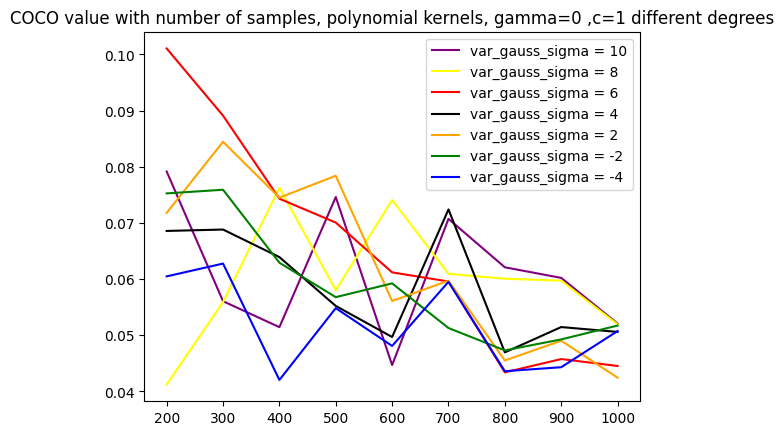

In [40]:
from sympy.stats import Normal,E
from sympy import exp,sqrt,N

m = 1000
start_point = 200
step= 100
gamma = 0
degrees = np.array([-4,-2,2,4,6,8,10])
res_degrees = np.empty((len(degrees),(m-start_point)//step +1))
x_axis = np.array(list(range(start_point,m+1,step)))
colors = ['blue','green',"orange","black","red","yellow","purple"]
if len(colors)!=len(degrees):
    raise ValueError("the numbers of colors doesn't match the number of gamma value given")
cov = np.identity(4)
cov[1][0] =  0.5
cov[0][1] =  0.5
cov[1][2] =  0.25
cov[2][1] =  0.25
cov[2][3] =  0.75
cov[3][2] =  0.75
mean = np.array([0,0,0,0])


for i in tqdm(range(len(degrees))):
    c = 1
    d = degrees[i]
    Kf_d = lambda x,y : K_polynomial(x,y,c,d)
    Kg_d = lambda x,y : K_polynomial(x,y,c,d)
    for j in tqdm(range(start_point,m+1,step)):
        k = (j-start_point)//step
        x = np.random.normal(0,1,j)
        y = gamma*x + np.sqrt(1-gamma**2)*np.random.normal(0,1,j)
        res_degrees[i][k] = COCO(Kf_d,Kg_d,x,y)



for i in range(1,len(degrees)+1):
    plt.plot(x_axis,res_degrees[-i],color = colors[-i], label ="var_gauss_sigma = {}".format(degrees[-i]))
plt.title("COCO value with number of samples, polynomial kernels, gamma={} ,c={} different degrees".format(gamma,c))
plt.legend()
plt.show()

### Implementing HSIC
From (9) in HSIC paper we have: $$HSIC_{emp}(Z,F,G)=(m-1)^{-2} \bold{tr}KHLH $$
$$where\; H,K,L \in \mathbb(R)^{m\times m},K_{ij}:=k(x_i,x_j),L_{ij}:=l(y_i,y_j) \; and\; H_ij:=\delta_{ij}-m^{-1}$$

In [34]:
def HSIC(k:callable,l:callable,x:np.array,y:np.array):
    """This function computes the Hilbert-Schmidt Independence Criterion for two kernels and some samples
    Args:
        k : first kernel
        l : second kernel
        x : samples from F
        y : samples from G
    Returns:
        HSIC_emp
    """
    m = len(x)
    K = np.array([list( map_kernel_gram(i,j,x,k) for i in range(m)) for j in range(m)])
    L = np.array([list( map_kernel_gram(i,j,y,l) for i in range(m)) for j in range(m)])
    H = np.array([list( map_projection_op(i,j,m) for i in range(m)) for j in range(m)])
    res_mat = np.matmul(K,np.matmul(H,np.matmul(L,H)))

    return np.trace(res_mat)*(m-1)**(-2)

In [35]:
from sympy.stats import Normal,E
from sympy import exp,sqrt,N
factor = 1
gamma = 0
gamma_bar = sqrt(1- gamma**2)
X = Normal('X',0,1)
X1 = Normal('X1',0,1)
Z = Normal('Z',0,1)
Z1 = Normal('Z1',0,1)
Y = gamma*X + gamma_bar*Z
Y1 = gamma*X1 + gamma_bar*Z1
W = Normal('W',0,sqrt(2) )  #X-X1
V = Normal('V',0,sqrt(2) )  #Z-Z1
Ex1y1_x2y2 = 1/sqrt(1+8*factor*(1+2*factor*(gamma_bar**2)))
Ex1y1_Ex2y2 = 1/(4*factor+1) 
Ex1y1_Ex2Ey2=1/sqrt( (2*factor+1+2*factor*gamma_bar**2)*(4*factor+1+2*factor*gamma**2)-4*(factor*gamma*gamma_bar)**2)
Ex1y1_x2y2_prime = E(exp(-factor*((1+gamma**2)*W**2 +(gamma_bar*V)**2 +2*gamma*gamma_bar*W*V )))
Ex1y1_Ex2y2_prime = E(exp(-factor*(W)**2))*E(exp(-factor*(V)**2)) 
Ex1y1_Ex2Ey2_prime = E(exp((-factor/(2*factor+1))*((1+gamma**2)*X**2-2*gamma*gamma_bar*Z*X+(gamma_bar*Z)**2)))/(2*factor+1)
print('term1=',N(Ex1y1_x2y2),"term1_prime=",N(Ex1y1_x2y2_prime))
print('term2=',Ex1y1_Ex2y2,"term2_prime=",N(Ex1y1_Ex2y2_prime))
print('term3=',N(Ex1y1_Ex2Ey2),"term3_prime=",N(Ex1y1_Ex2Ey2_prime))
HSIC_pop = Ex1y1_x2y2 + Ex1y1_Ex2y2 - 2*Ex1y1_Ex2Ey2
print("HSIC_pop=",HSIC_pop,"numerical =",N(HSIC_pop))

term1= 0.200000000000000 term1_prime= 0.200000000000000
term2= 0.2 term2_prime= 0.200000000000000
term3= 0.200000000000000 term3_prime= 0.200000000000000
HSIC_pop= 0 numerical = 0


100%|██████████| 9/9 [00:27<00:00,  3.06s/it]


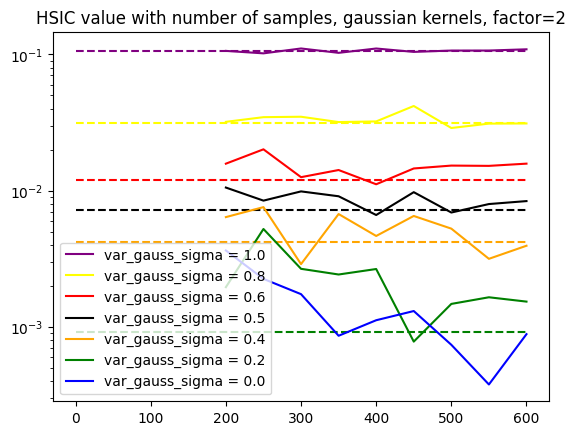

In [36]:
from sympy.stats import Normal,E
from sympy import exp,sqrt,N
factor = 2
Kf = lambda x,y : K_gaussian(x,y,factor)
Kg = lambda x,y : K_gaussian(x,y,factor)


m = 600
start_point = 200
step= 50
gamma = np.array([0,0.2,0.4,0.5,0.6,0.8,1])
gamma_bar= np.sqrt(1-gamma**2)
res_gammas = np.empty((len(gamma),(m-start_point)//step +1))
x_axis = np.array(list(range(start_point,m+1,step)))
colors = ['blue','green',"orange","black","red","yellow","purple"]
if len(colors)!=len(gamma):
    raise ValueError("the numbers of colors doesn't match the number of gamma value given")



for j in tqdm(range(start_point,m+1,step)):
    for i in range(len(gamma)):
        k = (j-start_point)//step
        x = np.random.normal(0,1,j)
        y = gamma[i]*x + gamma_bar[i]*np.random.normal(0,1,j)
        res_gammas[i][k] = HSIC(Kf,Kg,x,y)

X = Normal('X',0,1)
Y = Normal('Y',0,1)
W = Normal('W',0,sqrt(2))
V = Normal('V',0,sqrt(2))


for i in range(1,len(gamma)+1):
    gamma_i = gamma[-i]
    gamma_bar_i = sqrt(1-gamma_i**2)
    Ex1y1_x2y2 = 1/sqrt(1+8*factor*(1+2*factor*(gamma_bar_i**2)))
    Ex1y1_Ex2y2 = 1/(4*factor+1)
    Ex1y1_Ex2Ey2 = 1/sqrt( (2*factor+1+2*factor*gamma_bar_i**2)*(4*factor+1+2*factor*gamma_i**2)-4*(factor*gamma_i*gamma_bar_i)**2)
    HSIC_pop_i = Ex1y1_x2y2 + Ex1y1_Ex2y2 -2*Ex1y1_Ex2Ey2
    plt.hlines(HSIC_pop_i,xmin=0,xmax = x_axis[-1],color = colors[-i],linestyles= "--")
    plt.title("HSIC value with number of samples, gaussian kernels, factor={}".format(factor))
    plt.plot(x_axis,res_gammas[-i],color = colors[-i], label ="var_gauss_sigma = {}".format(gamma_i))
plt.yscale('log')
plt.legend()
plt.show()

100%|██████████| 21/21 [16:21<00:00, 46.73s/it] 


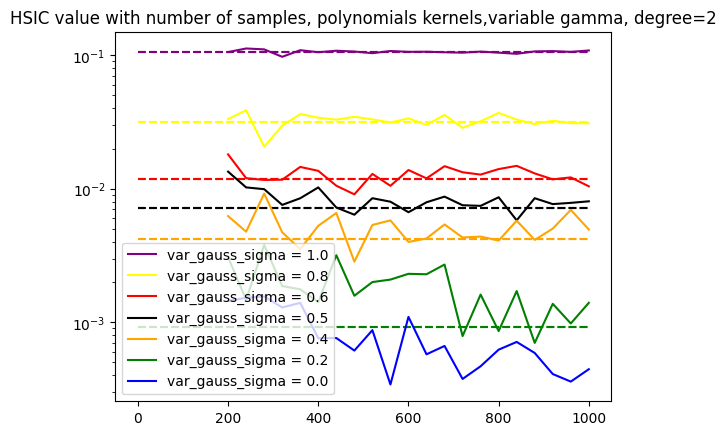

In [37]:
from sympy.stats import Normal,E
from sympy import exp,sqrt,N
c = 0 # constant
d = 2 # degree of the polyomial

Kf = lambda x,y : K_polynomial(x,y,c,d)
Kg = lambda x,y : K_polynomial(x,y,c,d)


m = 1000
start_point = 200
step= 40
gamma = np.array([0,0.2,0.4,0.5,0.6,0.8,1])
gamma_bar= np.sqrt(1-gamma**2)
res_gammas = np.empty((len(gamma),(m-start_point)//step +1))
x_axis = np.array(list(range(start_point,m+1,step)))
colors = ['blue','green',"orange","black","red","yellow","purple"]
if len(colors)!=len(gamma):
    raise ValueError("the numbers of colors doesn't match the number of gamma value given")



for j in tqdm(range(start_point,m+1,step)):
    for i in range(len(gamma)):
        k = (j-start_point)//step
        x = np.random.normal(0,1,j)
        y = gamma[i]*x + gamma_bar[i]*np.random.normal(0,1,j)
        res_gammas[i][k] = HSIC(Kf,Kg,x,y)

X = Normal('X',0,1)
Y = Normal('Y',0,1)
W = Normal('W',0,sqrt(2))
V = Normal('V',0,sqrt(2))


for i in range(1,len(gamma)+1):
    gamma_i = gamma[-i]
    gamma_bar_i = sqrt(1-gamma_i**2)
    Ex1y1_x2y2 = 1/sqrt(1+8*factor*(1+2*factor*(gamma_bar_i**2)))
    Ex1y1_Ex2y2 = 1/(4*factor+1)
    Ex1y1_Ex2Ey2 = 1/sqrt( (2*factor+1+2*factor*gamma_bar_i**2)*(4*factor+1+2*factor*gamma_i**2)-4*(factor*gamma_i*gamma_bar_i)**2)
    HSIC_pop_i = Ex1y1_x2y2 + Ex1y1_Ex2y2 -2*Ex1y1_Ex2Ey2
    #Ex1y1_x2y2_prime = E(exp(-factor*((1+gamma**2)*W**2 +(gamma_bar*V)**2 +2*gamma*gamma_bar*W*V )))
    #Ex1y1_Ex2y2_prime = E(exp(-factor*(W)**2))*E(exp(-factor*(V)**2)) 
    #Ex1y1_Ex2Ey2_prime = E(exp((-factor/(2*factor+1))*((1+gamma**2)*X**2-2*gamma*gamma_bar*Z*X+(gamma_bar*Z)**2)))/(2*factor+1)
    #HSIC_pop_i_prime = Ex1y1_x2y2_prime + Ex1y1_Ex2y2_prime -2*Ex1y1_Ex2Ey2_prime
    plt.hlines(HSIC_pop_i,xmin=0,xmax = x_axis[-1],color = colors[-i],linestyles= "--")
    plt.title("HSIC value with number of samples, polynomials kernels,variable gamma, degree={}".format(d))
    plt.hlines(HSIC_pop_i,xmin=0,xmax = x_axis[-1],color = colors[-i],linestyles= "--")
    plt.plot(x_axis,res_gammas[-i],color = colors[-i], label ="var_gauss_sigma = {}".format(gamma_i))
plt.yscale('log')
plt.legend()
plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [12:49<00:00, 109.86s/it]


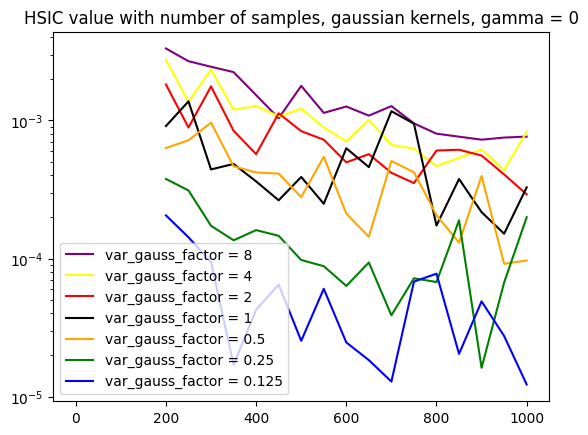

In [38]:
from sympy.stats import Normal,E
from sympy import exp,sqrt,N
factor = 1
Kf = lambda x,y : K_gaussian(x,y,factor)
Kg = lambda x,y : K_gaussian(x,y,factor)


m = 1000
start_point = 200
step= 50
gamma = 0
gamma_bar= np.sqrt(1-gamma**2)
factors = [1/8,1/4,1/2,1,2,4,8]
res_factors = np.empty((len(factors),(m-start_point)//step +1))
x_axis = np.array(list(range(start_point,m+1,step)))
colors = ['blue','green',"orange","black","red","yellow","purple"]
if len(colors)!=len(factors):
    raise ValueError("the numbers of colors doesn't match the number of gamma value given")



for i in tqdm(range(len(factors))):
    factor_i = factors[i]
    Kf_i = lambda x,y : K_gaussian(x,y,factor_i)
    Kg_i = lambda x,y : K_gaussian(x,y,factor_i)    

    for j in tqdm(range(start_point,m+1,step)):
        k = (j-start_point)//step
        x = np.random.normal(0,1,j)
        y = gamma*x +gamma_bar*np.random.normal(0,1,j)
        res_factors[i][k] = HSIC(Kf_i,Kg_i,x,y)

X = Normal('X',0,1)
Y = Normal('Y',0,1)
W = Normal('W',0,sqrt(2))
V = Normal('V',0,sqrt(2))


for i in range(1,len(factors)+1):
    factor_i = factors[-i]
    Ex1y1_x2y2 = 1/sqrt(1+8*factor_i*(1+2*factor_i*(gamma_bar**2)))
    Ex1y1_Ex2y2 = 1/(4*factor_i+1)
    Ex1y1_Ex2Ey2 = 1/sqrt( (2*factor_i+1+2*factor_i*gamma_bar**2)*(4*factor_i+1+2*factor_i*gamma**2)-4*(factor_i*gamma*gamma_bar)**2)
    HSIC_pop_i = Ex1y1_x2y2 + Ex1y1_Ex2y2 -2*Ex1y1_Ex2Ey2
    plt.hlines(HSIC_pop_i,xmin=0,xmax = x_axis[-1],color = colors[-i],linestyles= "--")
    plt.plot(x_axis,res_factors[-i],color = colors[-i], label ="var_gauss_factor = {}".format(factor_i))
plt.title("HSIC value with number of samples, gaussian kernels, gamma = {}".format(gamma))
plt.yscale('log')
plt.legend()
plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [08:18<00:00, 71.22s/it]


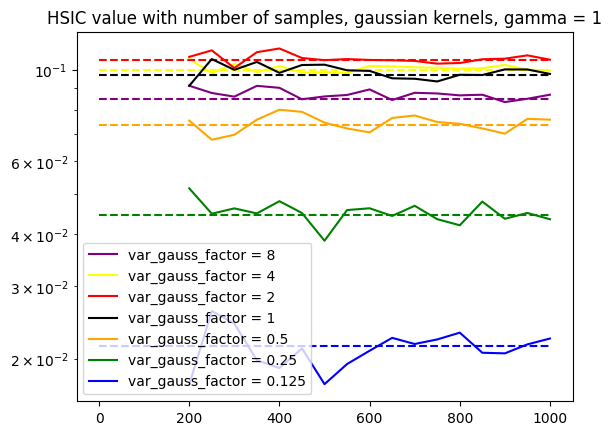

In [39]:
from sympy.stats import Normal,E
from sympy import exp,sqrt,N
factor = 1
Kf = lambda x,y : K_gaussian(x,y,factor)
Kg = lambda x,y : K_gaussian(x,y,factor)


m = 1000
start_point = 200
step= 50
gamma = 1
gamma_bar= np.sqrt(1-gamma**2)
factors = [1/8,1/4,1/2,1,2,4,8]
res_factors = np.empty((len(factors),(m-start_point)//step +1))
x_axis = np.array(list(range(start_point,m+1,step)))
colors = ['blue','green',"orange","black","red","yellow","purple"]
if len(colors)!=len(factors):
    raise ValueError("the numbers of colors doesn't match the number of gamma value given")



for i in tqdm(range(len(factors))):
    factor_i = factors[i]
    Kf_i = lambda x,y : K_gaussian(x,y,factor_i)
    Kg_i = lambda x,y : K_gaussian(x,y,factor_i)    

    for j in tqdm(range(start_point,m+1,step)):
        k = (j-start_point)//step
        x = np.random.normal(0,1,j)
        y = gamma*x + gamma_bar*np.random.normal(0,1,j)
        res_factors[i][k] = HSIC(Kf_i,Kg_i,x,y)

X = Normal('X',0,1)
Y = Normal('Y',0,1)
W = Normal('W',0,sqrt(2))
V = Normal('V',0,sqrt(2))


for i in range(1,len(factors)+1):
    factor_i = factors[-i]
    Ex1y1_x2y2 = 1/sqrt(1+8*factor_i*(1+2*factor_i*(gamma_bar**2)))
    Ex1y1_Ex2y2 = 1/(4*factor_i+1)
    Ex1y1_Ex2Ey2 = 1/sqrt( (2*factor_i+1+2*factor_i*gamma_bar**2)*(4*factor_i+1+2*factor_i*gamma**2)-4*(factor_i*gamma*gamma_bar)**2)
    HSIC_pop_i = Ex1y1_x2y2 + Ex1y1_Ex2y2 -2*Ex1y1_Ex2Ey2
    plt.hlines(HSIC_pop_i,xmin=0,xmax = x_axis[-1],color = colors[-i],linestyles= "--")
    plt.plot(x_axis,res_factors[-i],color = colors[-i], label ="var_gauss_factor = {}".format(factor_i))
plt.title("HSIC value with number of samples, gaussian kernels, gamma = {}".format(gamma))
plt.yscale('log')
plt.legend()
plt.show()